# Sentiment Analysis using Reviews of customers

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime as dt
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, Normalizer, OneHotEncoder
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix, f1_score
from xgboost import XGBClassifier
from scipy.sparse import hstack
from imblearn.over_sampling import SMOTE
from prettytable import PrettyTable

import re
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# # importing the data

# customers_dataset=pd.read_csv("../input/python-for-ds-datasets-venkat/Brazil_Ecom_data_All_Data_Files/olist_customers_dataset.csv")
# geolocation_dataset=pd.read_csv("../input/python-for-ds-datasets-venkat/Brazil_Ecom_data_All_Data_Files/olist_geolocation_dataset.csv")
# order_items_dataset=pd.read_csv("../input/python-for-ds-datasets-venkat/Brazil_Ecom_data_All_Data_Files/olist_order_items_dataset.csv")
# order_payments_dataset=pd.read_csv('../input/python-for-ds-datasets-venkat/Brazil_Ecom_data_All_Data_Files/olist_order_payments_dataset.csv')
# order_reviews_dataset=pd.read_csv('../input/python-for-ds-datasets-venkat/Brazil_Ecom_data_All_Data_Files/olist_order_reviews_dataset.csv')
# orders_dataset=pd.read_csv('../input/python-for-ds-datasets-venkat/Brazil_Ecom_data_All_Data_Files/olist_orders_dataset.csv')
# products_dataset=pd.read_csv('../input/python-for-ds-datasets-venkat/Brazil_Ecom_data_All_Data_Files/olist_products_dataset.csv')
# sellers_dataset=pd.read_csv('../input/python-for-ds-datasets-venkat/Brazil_Ecom_data_All_Data_Files/olist_sellers_dataset.csv')
# product_category_name_translation=pd.read_csv('../input/python-for-ds-datasets-venkat/Brazil_Ecom_data_All_Data_Files/product_category_name_translation.csv')

In [3]:
# Importing the data
customers_dataset=pd.read_csv("olist_customers_dataset.csv")
geolocation_dataset=pd.read_csv("olist_geolocation_dataset.csv")
order_items_dataset=pd.read_csv("olist_order_items_dataset.csv")
order_payments_dataset=pd.read_csv('olist_order_payments_dataset.csv')
order_reviews_dataset=pd.read_csv('olist_order_reviews_dataset.csv')
orders_dataset=pd.read_csv('olist_orders_dataset.csv')
products_dataset=pd.read_csv('olist_products_dataset.csv')
sellers_dataset=pd.read_csv('olist_sellers_dataset.csv')
product_category_name_translation=pd.read_csv('product_category_name_translation.csv')

In [4]:
order_reviews_dataset.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [5]:
order_reviews_dataset.columns

Index(['review_id', 'order_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp'],
      dtype='object')

In [6]:
df=order_reviews_dataset.drop(['review_id', 'order_id', 'review_comment_title',
        'review_creation_date','review_answer_timestamp'],axis=1)

In [7]:
df.dropna(inplace=True)

In [8]:
print('Data lost(%) = ',(1-len(df)/len(order_reviews_dataset))*100)

Data lost(%) =  58.61449803991614


In [9]:
df.head()

,review_score,review_comment_message
3,5,Recebi bem antes do prazo estipulado.
4,5,Parabéns lojas lannister adorei comprar pela I...
9,4,aparelho eficiente. no site a marca do aparelh...
12,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n"
15,5,"Vendedor confiável, produto ok e entrega antes..."


#### Since it is more important to predict the bad reviews correctly, we will be converting all the reviews that are less than 4 to 1(Bad Review) and ratings more than 3 to 0(Not a bad review). This will help us in maximise the correct bad reviews predictions

In [10]:
df['review_score']=df['review_score'].apply(lambda x: 1 if x<4 else 0)

In [11]:
df['review_score'].value_counts()

0    28521
1    15502
Name: review_score, dtype: int64

In [12]:
texts=df['review_comment_message']

### Wordcloud

In [13]:
nltk.download('stopwords')
stop_words= set(stopwords.words('portuguese'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


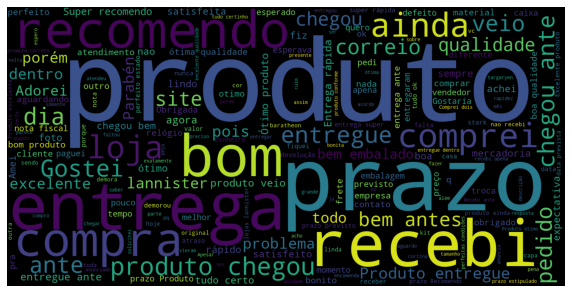

In [14]:
wordcloud=WordCloud(stopwords=stop_words,background_color='black',width=1600,height=800).generate(' '.join(texts))

fig,ax=plt.subplots(figsize=(10,6))
ax.imshow(wordcloud,interpolation='bilinear')
ax.set_axis_off()

plt.imshow(wordcloud)

In [15]:
y=df['review_score']
X=df.drop(['review_score'],axis=1)

In [16]:
print(X.shape,y.shape)

(44023, 1) (44023,)


## Preprocessing 

In [17]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

In [18]:
def pre_process_data(text):
    lemm = WordNetLemmatizer()
    text  = re.sub(r"[^0-9a-zA-Z]+",' ',text)
    tokenized = word_tokenize(text)
    text = [lemm.lemmatize(i.lower()) for i in tokenized if not(i.lower() in stop_words) and i.isalpha()]
    return ' '.join(text)

In [19]:
texts=[pre_process_data(txt) for txt in texts]

In [20]:
X=pd.DataFrame(texts)
X.head()

,0
0,recebi bem ante prazo estipulado
1,parab n lojas lannister adorei comprar interne...
2,aparelho eficiente site marca aparelho impress...
3,pouco travando valor ta boa
4,vendedor confi vel produto ok entrega ante prazo


In [21]:
X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=y,test_size=0.3,shuffle=True)

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(30816, 1) (30816,)
(13207, 1) (13207,)


## Bag Of Words

In [22]:
bow=CountVectorizer(min_df=5,ngram_range=(1,4),max_features=10000)

X_train_bow=bow.fit_transform(X_train.values.flatten())
X_test_bow=bow.transform(X_test.values.flatten())

print(X_train_bow.shape)
print(X_test_bow.shape)

(30816, 9677)
(13207, 9677)


## TfIdf 

In [23]:
tfidf=TfidfVectorizer(min_df=5,ngram_range=(1,4),max_features=10000)

X_train_tfidf=tfidf.fit_transform(X_train.values.flatten())
X_test_tfidf=tfidf.transform(X_test.values.flatten())

print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

(30816, 9677)
(13207, 9677)


# Modeling

## GridSearchCV

In [24]:
def grid_search(estimator,param,X_train,y_train):
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2,random_state=1)
    clf=GridSearchCV(estimator=estimator,param_grid=param,cv=cv,refit=False,return_train_score=True,
                    scoring='roc_auc',n_jobs=-1)
    clf.fit(X_train,y_train)
    best_params=clf.best_params_
    print(best_params)
    
    return best_params

In [25]:
def predicting_values(model,X_train,X_test,y_train,y_test):
    
    # Predicting the binary values
    y_train_pred_value=model.predict(X_train)
    y_test_pred_value=model.predict(X_test)

    # Predicting the probability estimates of train and test dataset
    y_train_pred_prob=model.predict_proba(X_train)
    y_test_pred_prob=model.predict_proba(X_test)
    
    # Plotting ROC curve
    tr_fpr, tr_tpr, tr_thresholds=roc_curve(y_train,y_train_pred_prob[:,1])
    te_fpr, te_tpr, te_thresholds=roc_curve(y_test,y_test_pred_prob[:,1])

    auc_train_model=np.round(auc(tr_fpr,tr_tpr),4)
    auc_test_model=np.round(auc(te_fpr,te_tpr),4)


    plt.plot(tr_fpr,tr_tpr,label='Train AUC '+str(auc_train_model))
    plt.plot(te_fpr,te_tpr,label='Test AUC '+str(auc_test_model))
    plt.title('ROC curve')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend()
    plt.show()
    
    # Plotting Confusion Matrix
    c_train=confusion_matrix(y_train,y_train_pred_value)
    c_test=confusion_matrix(y_test,y_test_pred_value)

    plt.figure(figsize=(14,6))

    plt.subplot(1,2,1)
    sns.heatmap(c_train/np.sum(c_train),annot=True,fmt='.2%',cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title("Train Confusion Matrix")


    plt.subplot(1,2,2)
    sns.heatmap(c_test/np.sum(c_test),annot=True,fmt='.2%',cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title("Test Confusion Matrix")
    plt.show()
    

    tn,fp,fn,tp=c_test.ravel()
    # print(classification_report(y_test,y_test_pred_value))
    print()
    table=PrettyTable(['Metrics','Values'])
    table.add_row(['Specificity(%)',np.round((tn/(tn+fp))*100,2)])
    table.add_row(['Sensitivity/Recall(%)',np.round((tp/(tp+fn))*100,2)])
    table.add_row(['Precision(%)',np.round((tp/(tp+fp))*100,2)])
    table.add_row(['Micro F1 Score',np.round(f1_score(y_test,y_test_pred_value,average='micro'),2)])
    model_metrics=[np.round((tn/(tn+fp))*100,2),np.round((tp/(tp+fn))*100,2),np.round((tp/(tp+fp))*100,2),np.round(f1_score(y_test,y_test_pred_value,average='micro'),2),auc_train_model,auc_test_model]
    print(table)

    return model_metrics
   

## 1) Bag Of Words

### 1.1) Naive Bayes

{'alpha': 0.5}


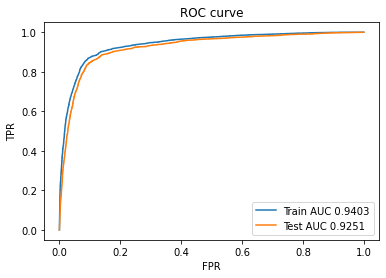

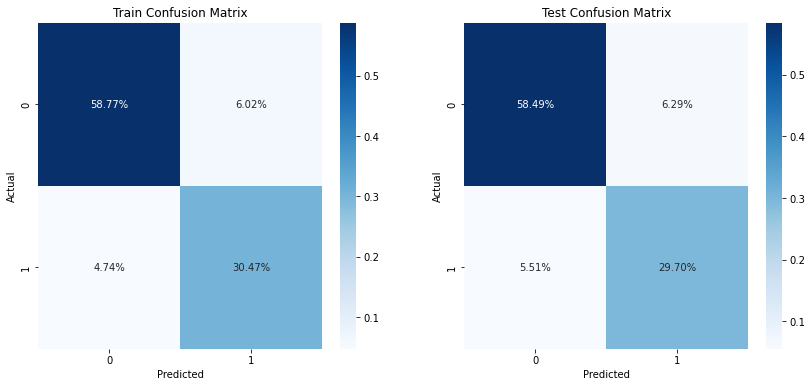


+-----------------------+--------+
|        Metrics        | Values |
+-----------------------+--------+
|     Specificity(%)    | 90.29  |
| Sensitivity/Recall(%) | 84.35  |
|      Precision(%)     | 82.52  |
|     Micro F1 Score    |  0.88  |
+-----------------------+--------+


In [26]:
model_1=MultinomialNB()
param={'alpha':[0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]}
best_params=grid_search(model_1,param,X_train_bow,y_train)

model_1=MultinomialNB(alpha=best_params['alpha'])
model_1.fit(X_train_bow,y_train)
model_1_metrics=predicting_values(model_1,X_train_bow,X_test_bow,y_train,y_test)

### 1.2) Logistic Regression

{'C': 1}


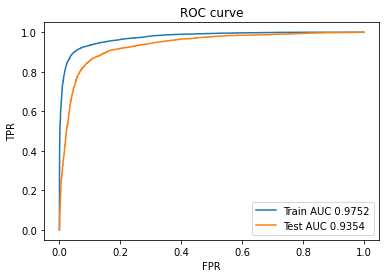

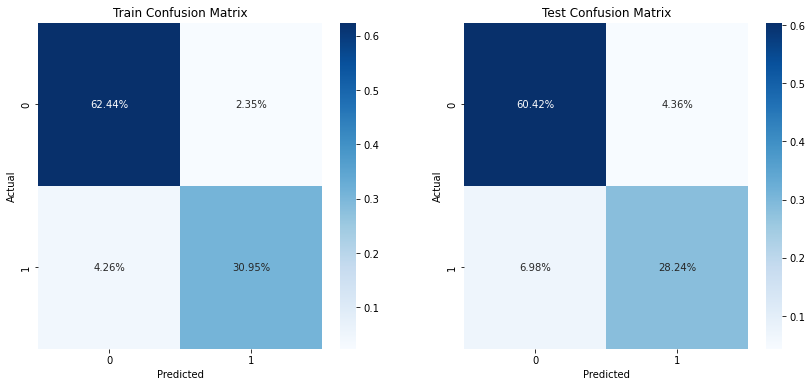


+-----------------------+--------+
|        Metrics        | Values |
+-----------------------+--------+
|     Specificity(%)    | 93.27  |
| Sensitivity/Recall(%) | 80.18  |
|      Precision(%)     | 86.62  |
|     Micro F1 Score    |  0.89  |
+-----------------------+--------+


In [27]:
model_2=LogisticRegression(max_iter=1000)
param={'C':[0.001,0.01,0.1,1,10,20,30]}
best_params=grid_search(model_2,param,X_train_bow,y_train.ravel())

model_2=LogisticRegression(C=best_params['C'],max_iter=1000)
model_2.fit(X_train_bow,y_train.ravel())

model_2_metrics=predicting_values(model_2,X_train_bow,X_test_bow,y_train,y_test)

### 1.3) Decision Trees

{'max_depth': 20, 'min_samples_split': 150}


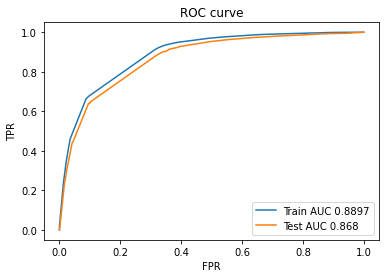

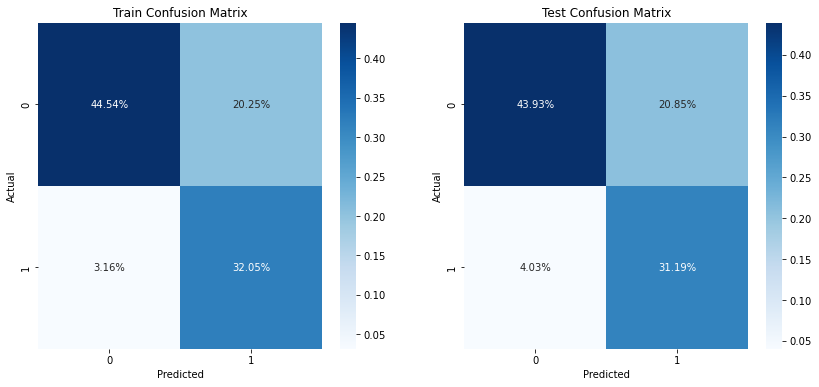


+-----------------------+--------+
|        Metrics        | Values |
+-----------------------+--------+
|     Specificity(%)    | 67.81  |
| Sensitivity/Recall(%) | 88.56  |
|      Precision(%)     | 59.93  |
|     Micro F1 Score    |  0.75  |
+-----------------------+--------+


In [28]:
model_3=DecisionTreeClassifier(class_weight='balanced')
param={'max_depth':[2,5,10,15,20],'min_samples_split':[10,50,100,150,300,500,1000,1500]}
best_params=grid_search(model_3,param,X_train_bow,y_train.ravel())

model_3=DecisionTreeClassifier(class_weight='balanced',max_depth=best_params['max_depth'],
                              min_samples_split=best_params['min_samples_split'])
model_3.fit(X_train_bow,y_train.ravel())

model_3_metrics=predicting_values(model_3,X_train_bow,X_test_bow,y_train,y_test)

### 1.4) Random Forest

{'max_depth': 9, 'min_samples_split': 2}


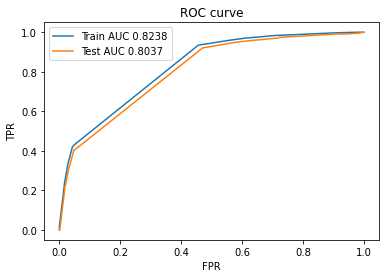

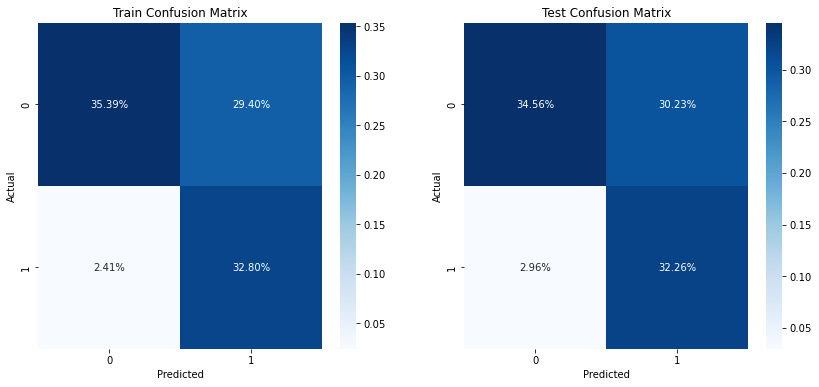


+-----------------------+--------+
|        Metrics        | Values |
+-----------------------+--------+
|     Specificity(%)    | 53.34  |
| Sensitivity/Recall(%) | 91.59  |
|      Precision(%)     | 51.62  |
|     Micro F1 Score    |  0.67  |
+-----------------------+--------+


In [29]:
model_4=RandomForestClassifier(class_weight='balanced')
param={'max_depth':[2,5,7,9],'min_samples_split':[2,3,6,10,15,30]}
best_params=grid_search(model_4,param,X_train_bow,y_train.ravel())

model_4=DecisionTreeClassifier(class_weight='balanced',max_depth=best_params['max_depth'],
                              min_samples_split=best_params['min_samples_split'])
model_4.fit(X_train_bow,y_train.ravel())

model_4_metrics=predicting_values(model_4,X_train_bow,X_test_bow,y_train,y_test)

### 1.5) XG Boost

{'learning_rate': 0.2, 'max_depth': 15}


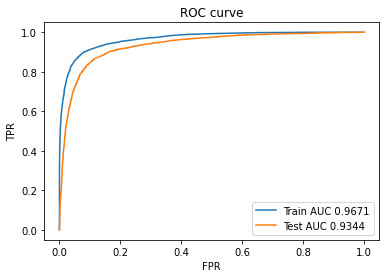

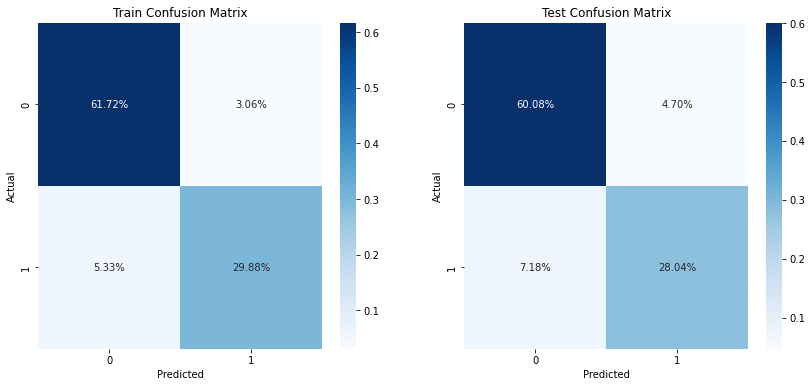


+-----------------------+--------+
|        Metrics        | Values |
+-----------------------+--------+
|     Specificity(%)    | 92.74  |
| Sensitivity/Recall(%) | 79.62  |
|      Precision(%)     | 85.64  |
|     Micro F1 Score    |  0.88  |
+-----------------------+--------+


In [30]:
model_5=XGBClassifier()
param={'max_depth':[5,7,10,15],"learning_rate":[0.05, 0.10, 0.15, 0.20 ]}
best_params=grid_search(model_5,param,X_train_bow,y_train.ravel())

model_5=XGBClassifier(max_depth=best_params['max_depth'],learning_rate=best_params['learning_rate'])
model_5.fit(X_train_bow,y_train.ravel())

model_5_metrics=predicting_values(model_5,X_train_bow,X_test_bow,y_train,y_test)

## 2) TfIdf

### 2.1) Naive Bayes

{'alpha': 0.5}


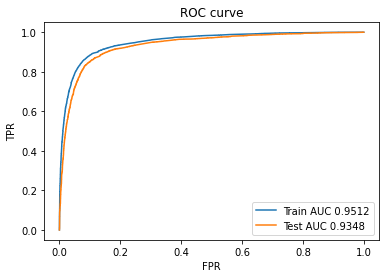

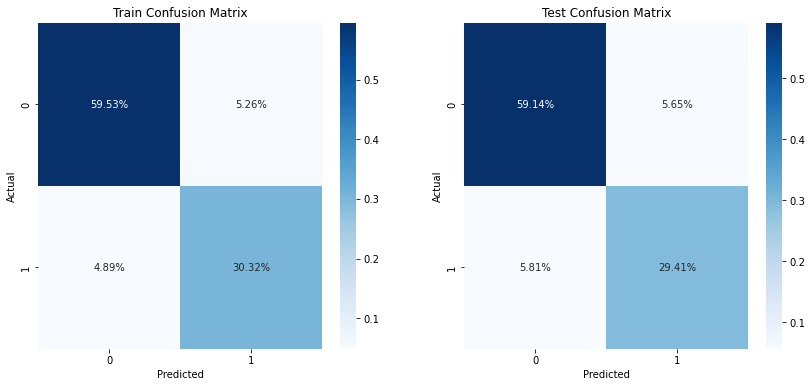


+-----------------------+--------+
|        Metrics        | Values |
+-----------------------+--------+
|     Specificity(%)    | 91.28  |
| Sensitivity/Recall(%) | 83.51  |
|      Precision(%)     | 83.89  |
|     Micro F1 Score    |  0.89  |
+-----------------------+--------+


In [31]:
model_6=MultinomialNB()
param={'alpha':[0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]}
best_params=grid_search(model_6,param,X_train_tfidf,y_train)

model_6=MultinomialNB(alpha=best_params['alpha'])
model_6.fit(X_train_tfidf,y_train)
model_6_metrics=predicting_values(model_6,X_train_tfidf,X_test_tfidf,y_train,y_test)

### 2.2) Logistic Regression

{'C': 1}


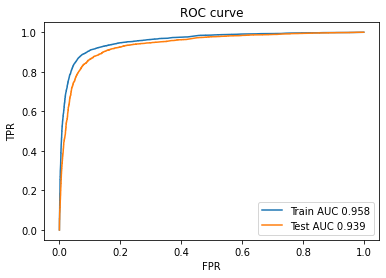

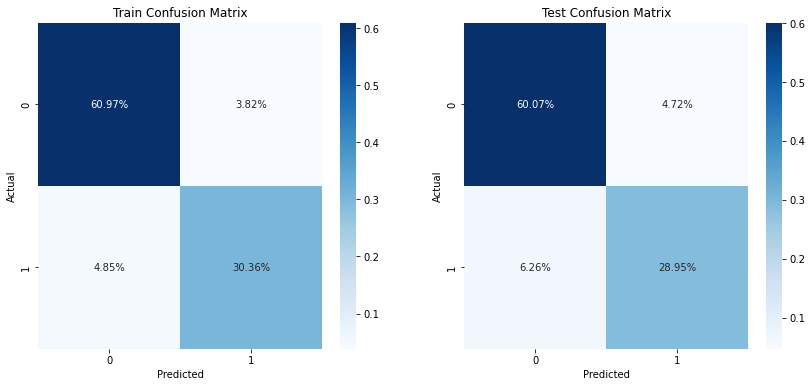


+-----------------------+--------+
|        Metrics        | Values |
+-----------------------+--------+
|     Specificity(%)    | 92.72  |
| Sensitivity/Recall(%) | 82.22  |
|      Precision(%)     | 85.99  |
|     Micro F1 Score    |  0.89  |
+-----------------------+--------+


In [32]:
model_7=LogisticRegression(max_iter=1000)
param={'C':[0.001,0.01,0.1,1,10,20,30]}
best_params=grid_search(model_7,param,X_train_tfidf,y_train.ravel())

model_7=LogisticRegression(C=best_params['C'],max_iter=1000)
model_7.fit(X_train_tfidf,y_train.ravel())

model_7_metrics=predicting_values(model_7,X_train_tfidf,X_test_tfidf,y_train,y_test)

### 2.3) Decision Trees

{'max_depth': 20, 'min_samples_split': 100}


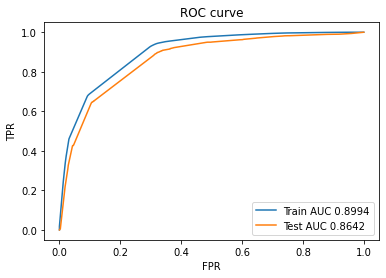

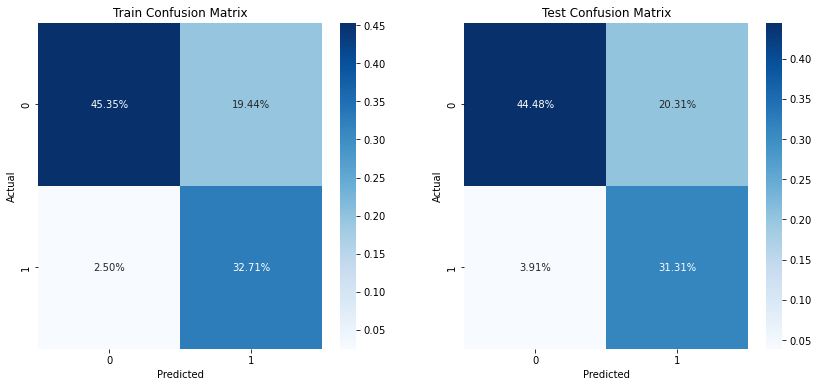


+-----------------------+--------+
|        Metrics        | Values |
+-----------------------+--------+
|     Specificity(%)    | 68.65  |
| Sensitivity/Recall(%) | 88.91  |
|      Precision(%)     | 60.66  |
|     Micro F1 Score    |  0.76  |
+-----------------------+--------+


In [33]:
model_8=DecisionTreeClassifier(class_weight='balanced')
param={'max_depth':[2,5,10,15,20],'min_samples_split':[10,50,100,150,300,500,1000,1500]}
best_params=grid_search(model_8,param,X_train_tfidf,y_train.ravel())

model_8=DecisionTreeClassifier(class_weight='balanced',max_depth=best_params['max_depth'],
                              min_samples_split=best_params['min_samples_split'])
model_8.fit(X_train_tfidf,y_train.ravel())

model_8_metrics=predicting_values(model_8,X_train_tfidf,X_test_tfidf,y_train,y_test)

### 2.4) Random Forest

{'max_depth': 9, 'min_samples_split': 6}


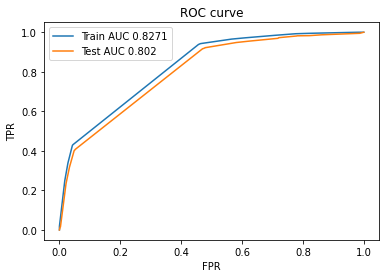

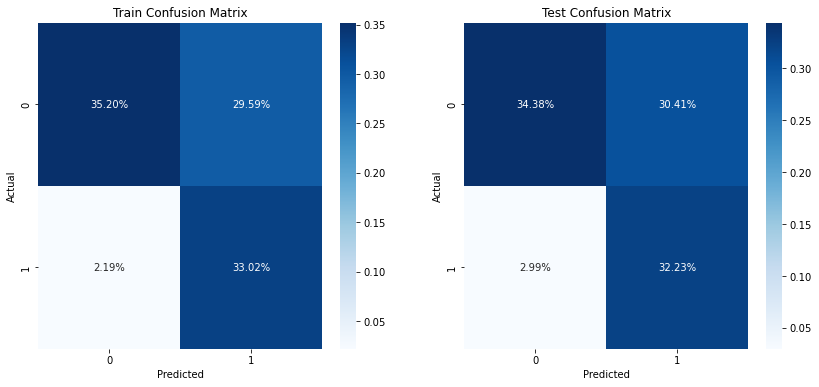


+-----------------------+--------+
|        Metrics        | Values |
+-----------------------+--------+
|     Specificity(%)    | 53.06  |
| Sensitivity/Recall(%) | 91.51  |
|      Precision(%)     | 51.45  |
|     Micro F1 Score    |  0.67  |
+-----------------------+--------+


In [34]:
model_9=RandomForestClassifier(class_weight='balanced')
param={'max_depth':[2,5,7,9],'min_samples_split':[2,3,6,10,15,30]}
best_params=grid_search(model_9,param,X_train_tfidf,y_train.ravel())

model_9=DecisionTreeClassifier(class_weight='balanced',max_depth=best_params['max_depth'],
                              min_samples_split=best_params['min_samples_split'])
model_9.fit(X_train_tfidf,y_train.ravel())

model_9_metrics=predicting_values(model_9,X_train_tfidf,X_test_tfidf,y_train,y_test)

### 2.5) XG Boost

{'learning_rate': 0.2, 'max_depth': 15}


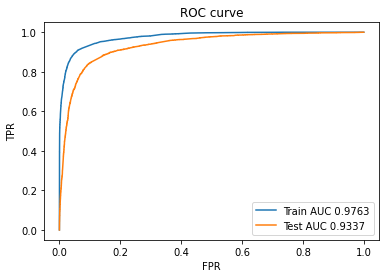

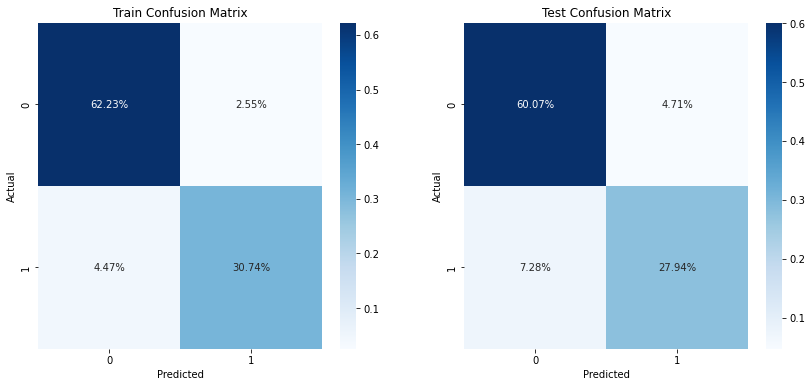


+-----------------------+--------+
|        Metrics        | Values |
+-----------------------+--------+
|     Specificity(%)    | 92.73  |
| Sensitivity/Recall(%) | 79.34  |
|      Precision(%)     | 85.58  |
|     Micro F1 Score    |  0.88  |
+-----------------------+--------+


In [35]:
model_10=XGBClassifier()
param={'max_depth':[5,7,10,15],"learning_rate":[0.05, 0.10, 0.15, 0.20 ]}
best_params=grid_search(model_10,param,X_train_tfidf,y_train.ravel())

model_10=XGBClassifier(max_depth=best_params['max_depth'],learning_rate=best_params['learning_rate'])
model_10.fit(X_train_tfidf,y_train.ravel())

model_10_metrics=predicting_values(model_10,X_train_tfidf,X_test_tfidf,y_train,y_test)

## Final Results

In [36]:
# final results
table=PrettyTable(['Model','Vectorizer','Specificity(%)','Recall(%)','Precision','F1 Score','Train AUC','Test AUC'])
table.add_row(['Naive Bayes','BOW',model_1_metrics[0],model_1_metrics[1],model_1_metrics[2],model_1_metrics[3],model_1_metrics[4],model_1_metrics[5]])
table.add_row(['Logistic Regression','BOW',model_2_metrics[0],model_2_metrics[1],model_2_metrics[2],model_2_metrics[3],model_2_metrics[4],model_2_metrics[5]])
table.add_row(['Decision Tree','BOW',model_3_metrics[0],model_3_metrics[1],model_3_metrics[2],model_3_metrics[3],model_3_metrics[4],model_3_metrics[5]])
table.add_row(['Random Forest','BOW',model_4_metrics[0],model_4_metrics[1],model_4_metrics[2],model_4_metrics[3],model_4_metrics[4],model_4_metrics[5]])
table.add_row(['XG Boost','BOW',model_5_metrics[0],model_5_metrics[1],model_5_metrics[2],model_5_metrics[3],model_5_metrics[4],model_5_metrics[5]])
table.add_row(['Naive Bayes','TfIdf',model_6_metrics[0],model_6_metrics[1],model_6_metrics[2],model_6_metrics[3],model_6_metrics[4],model_6_metrics[5]])
table.add_row(['Logistic Regression','TfIdf',model_7_metrics[0],model_7_metrics[1],model_7_metrics[2],model_7_metrics[3],model_7_metrics[4],model_7_metrics[5]])
table.add_row(['Decision Tree','TfIdf',model_8_metrics[0],model_8_metrics[1],model_8_metrics[2],model_8_metrics[3],model_8_metrics[4],model_8_metrics[5]])
table.add_row(['Random Forest','TfIdf',model_9_metrics[0],model_9_metrics[1],model_9_metrics[2],model_9_metrics[3],model_9_metrics[4],model_9_metrics[5]])
table.add_row(['XG Boost','TfIdf',model_10_metrics[0],model_10_metrics[1],model_10_metrics[2],model_10_metrics[3],model_10_metrics[4],model_10_metrics[5]])
print(table)

+---------------------+------------+----------------+-----------+-----------+----------+-----------+----------+
|        Model        | Vectorizer | Specificity(%) | Recall(%) | Precision | F1 Score | Train AUC | Test AUC |
+---------------------+------------+----------------+-----------+-----------+----------+-----------+----------+
|     Naive Bayes     |    BOW     |     90.29      |   84.35   |   82.52   |   0.88   |   0.9403  |  0.9251  |
| Logistic Regression |    BOW     |     93.27      |   80.18   |   86.62   |   0.89   |   0.9752  |  0.9354  |
|    Decision Tree    |    BOW     |     67.81      |   88.56   |   59.93   |   0.75   |   0.8897  |  0.868   |
|    Random Forest    |    BOW     |     53.34      |   91.59   |   51.62   |   0.67   |   0.8238  |  0.8037  |
|       XG Boost      |    BOW     |     92.74      |   79.62   |   85.64   |   0.88   |   0.9671  |  0.9344  |
|     Naive Bayes     |   TfIdf    |     91.28      |   83.51   |   83.89   |   0.89   |   0.9512  |  0.

- XG Boost performed the best followed by Naive Bayes and Logistic Regression
- TfIdf improved the performance of the model only slightly.